# Import modules

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import itertools
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer 
import pandas as pd
import csv
import spacy
import en_core_web_md

In [4]:
#download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Users\figohjs\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [5]:
#download wordnet for lemmatization
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     D:\Users\figohjs\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [6]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     D:\Users\figohjs\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [7]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     D:\Users\figohjs\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping chunkers\maxent_ne_chunker.zip.


True

In [8]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     D:\Users\figohjs\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

# Pre define parameters

In [6]:
confirmedFile = 'Data/Raw/Training_Data_Hani_CONFIRMED.txt'

neutralFile = 'Data/Raw/Training_Data_Hani_NEUTRAL.txt'

outputFile = 'Data/Interim/2019-09-24_ProcessedText.csv'

In [7]:
input966File = 'Data/Raw/Training_Data_966.txt'
output966File = 'Data/Interim/2019-09-30_ProcessedText_966.csv'

In [8]:
confirmedProcessedFile = 'Data/Interim/ConfirmedTextProcessed.csv'
neutralProcessedFile = 'Data/Interim/NeutralTextProcessed.csv'

In [56]:
nerModel = en_core_web_md.load()

# Read file

In [10]:
with open(confirmedFile, 'r') as myfile:
    confirmedText = myfile.readlines()

In [11]:
with open(neutralFile, 'r') as myfile:
    neutralText = myfile.readlines()

In [9]:
with open(input966File, 'r') as myfile:
    allText = myfile.readlines()

#processing for input file
allText = allText[1:-3]
textList = []
labelList = []
for text in allText:
    textList.append(re.sub('(\[|\")','',text.split(',')[0]).strip())
    if re.search('True',text.split(',')[1]):
        labelList.append(1)
    else:
        labelList.append(0)

# Processing

In [78]:
def removeNamedEntity(textArray):
    processedTextList = []
    neList = []
    #remove named entities
    for text in textArray:
        doc = nlp(text)
        NE = '|'.join([str(i) for i in doc.ents])
        neList.append(NE)
        processedTextList.append(re.sub(NE, '', text))
    return processedTextList

def removeHttps(textArray):
    result = []
    pattern = re.compile('(https*://[^ ]+)')
    for text in textArray:
        regexList = [re.escape(i) for i in re.findall(pattern, text)]
        if regexList:
            result.append(re.sub('|'.join(regexList), '', text))
        else:
            result.append(text)
    return result

def processText(text):
    #remove \n
    textList = [re.sub('\n', '', i) for i in text]
    
    #remove cardinal digit from Part-of-Speech tagger
#     filteredText = []
#     excludeTypeList = ['CD']
#     for text in textList:
#         taggedText = nltk.pos_tag(text.split(' '))
#         filteredText.append(' '.join([i[0] for i in taggedText if i[1] not in excludeTypeList]))'
    #remove named entity
    textList = removeNamedEntity(textList)
    
    #remove http or https
    textList = removeHttps(textList)
        
    #remove cardinal digit using regex
    regexList = ['\d+/\d+/\d+', 'rm\s*\d+\,\d+\.\d+', 'rm\s*\d+\,\d+',
                '\d+[a-z]*', '\d+']
    pattern = re.compile('|'.join(regexList))
    filteredText = []
    for text in textList:
        allMatches = re.findall(pattern, text)
        filteredText.append(re.sub('|'.join(allMatches), '', text))
    
    #remove stopwords
    processedText = []
    otherStopWords = ['also', 'via',  'within', ' even though ', 'on', 'please', 'still'
                     'pada', 'dan', 'sahaja', 'pula', 'juga', 
                     'yang', 'terdapat', 'oleh', 'telah', 'adalah', 'sejak',
                     'since']
    stopWordList = list(STOPWORDS) + otherStopWords
    for text in filteredText:
        processedText.append(' '.join([word for word in text.split(' ') if
                                      word not in stopWordList]))
        
    #use lemmatization
    processedText2 = []
    lemmatizer = WordNetLemmatizer() 
    for text in processedText:
        processedText2.append(' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')]))
    
    #remove punctuation and date
    strList = ['\.' , '\,', '\'s', '\"', '\'', '\{', '\}', '\%',
               'i\.e\.*', ' etc ', '(tt)* rm ', ' ie', ' rm ', ' rm']
    dateList = ['june', 'friday', 'april', 'march', ' may ', 'december', 'november', 
                ' nov ', 'july', 'feb', 'jun', 'october',
               'august', ' today ', 'september', 'february', ' a/c ', '//', 'january']
    toReplaceList = strList + dateList
    replaceList = ["" for i in toReplaceList]
    processedText2 = (pd.Series(processedText2).replace(to_replace = toReplaceList, value = replaceList, regex = True)\
                                    .replace(" +", " ", regex = True).str.strip()).values
    
    #remove just rm
    processedText2 = [re.sub('(^rm$|\s[a-zA-Z]\s)', '', text) for text in processedText2]
    
    return processedText2

In [90]:
confirmedTextProcessed = processText(confirmedText)
neutralTextProcessed = processText(neutralText)

In [79]:
processedTextList = processText(textList) 

In [115]:
processedTextList

['unable determine source fund activity',
 'suspect customeruse account illegal business activity',
 'doubtful genuineness exact purpose transaction',
 'activity detect inconsistent customer profile',
 'str submit far investigation',
 'customer mediazest market sdn bhd current account open ocbc alamin petaling jaya branch pjb',
 'account open form customer involve manufacture trade plastic injection mould incorporate',
 '',
 'customer try apply two telegraphic transfer tt usd',
 'due diligence check branch officer call one beneficiary greatland company pte ltd verify transaction contact numb provide invoice invalid',
 'far research internet reveal beneficiary',
 'marathon capital management limit venture investment',
 'invoice provide customer pay multipurpose efficient cnc router',
 'branch officer check application tt reject purpose transaction justified',
 '16 monday one signatory mediazest market sdn bhd come pjb request bank approve tt payment greatland company pte ltd marathon ca

In [ ]:
#write separately
with open(confirmedProcessedFile,'w') as resultFile:
    wr = csv.writer(resultFile, dialect='excel')
    for text in confirmedTextProcessed:
        wr.writerows([[text]])

with open(neutralProcessedFile,'w') as resultFile:
    wr = csv.writer(resultFile, dialect='excel')
    for text in neutralTextProcessed:
        wr.writerows([[text]])

In [102]:
#save to dataframe
allText = list(confirmedTextProcessed) + list(neutralTextProcessed)
label = [1]*len(confirmedTextProcessed) + [0]*len(neutralTextProcessed)
df = pd.DataFrame({'Text':allText, 'Label':label})
df.head()

,Text,Label
0,unable determine source fund activity,1
1,suspected customer might using account illegal...,1
2,doubtful genuineness exact purpose transaction,1
3,activity detected inconsistent customer profile,1
4,due diligence checking branch officer called o...,1


In [104]:
df.to_csv(outputFile, encoding = 'utf-8', index = False)

In [80]:
df = pd.DataFrame({'Text':processedTextList, 'Label':labelList})
df.head()

,Text,Label
0,unable determine source fund activity,1
1,suspect customeruse account illegal business a...,1
2,doubtful genuineness exact purpose transaction,1
3,activity detect inconsistent customer profile,1
4,str submit far investigation,0


In [81]:
df.to_csv(output966File, encoding = 'utf-8', index = False)

# Ngram

## Generate n-gram (list 0f n-gram) from list of text

In [83]:
def generateNGram(text, ngram = 2):
    listOfTuples = [list(nltk.ngrams(i.split(' '), ngram)) for i in text]
    flattenListOfTuples = list(itertools.chain(*listOfTuples))
    textNGram = ['_'.join(i) for i in flattenListOfTuples]
    
    return textNGram

# Word Cloud

## Generate word cloud out of list of text

In [84]:
#Function to generate word Cloud based on frequency
def generateWC(text, n = 10):
    #get a count vectorizer
    vectorizer = CountVectorizer()
    vectorizedText = vectorizer.fit_transform(text)
    CText_Dict = {}
    for i in zip(vectorizer.get_feature_names(), np.ravel(vectorizedText.sum(axis=0))):
        CText_Dict[i[0]] = i[1]
    #get top 10 keys/words based on frequency
    topText_Dict = dict(sorted(CText_Dict.items(), key = lambda x:x[1], reverse = True)[:n])
    
    #generate word cloud
    wordcloud = WordCloud(min_font_size = 10,
                         max_words = len(CText_Dict)).generate_from_frequencies(topText_Dict)

    plt.figure(figsize = (10, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    #return topText_Dict

In [85]:
def generateWConly(text):
    wordcloud = WordCloud(min_font_size = 10,
                         max_words = len(text)).generate_from_frequencies(text)
    
    plt.figure(figsize = (10, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()    

# Analysis

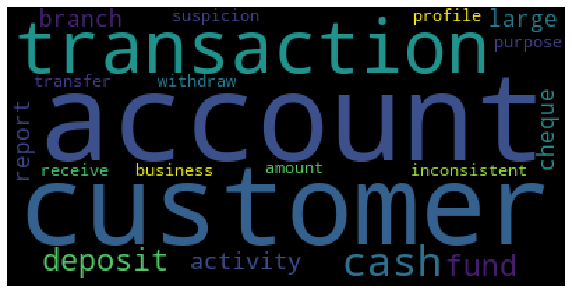

In [91]:
#top 10 keywords in confirmed text
confirmedText = df[df['Label'] == 1]['Text']
generateWC(confirmedText, 20)

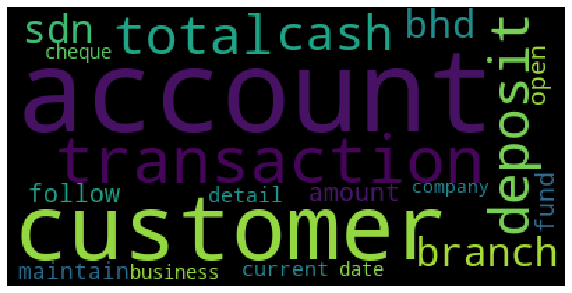

In [92]:
#top 10 keywords in neutral text
neutralText = df[df['Label'] == 0]['Text']
generateWC(neutralText, 20)

Both document show similarity in top 10 keywords: account, customer and transaction

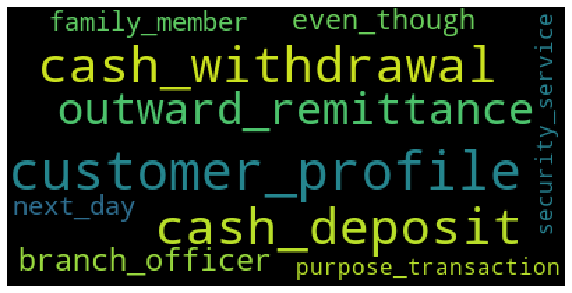

In [54]:
#top 10 bigrams in confirmed text
confirmedTextBigram = generateNGram(confirmedTextProcessed, 2)

generateWC(confirmedTextBigram, 10)

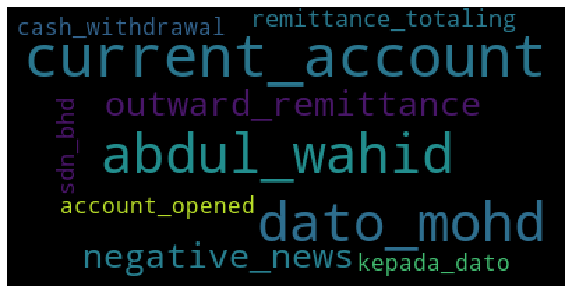

In [55]:
#top 10 bigrams in neutral text
neutralTextBigram = generateNGram(neutralTextProcessed, 2)

generateWC(neutralTextBigram, 10)

In confirmed text, there are meaningful bigrams like purpose transaction, customer profile, family member and cash deposit

# Term Frequency(TF)

In [56]:
Latex(r"""
        \begin{equation}
        \\
        \text{TF - 
        ratio of number of times the word appears in a document compared to the total number of words in that document}
        \\
        tf_{ij} = \frac{n_{ij}}{\sum{n_{ij}}}
        \\
        \text{where $n_{ij}$ is number of term $i$ in doc $j$ and
        $\sum{n_{ij}}$ is total of terms in all doc}
        \end{equation}
        """)

<IPython.core.display.Latex object>

# Inverse Doc Frequency(IDF)

In [57]:
Latex(r"""
        \begin{equation}
        \text{IDF - calculate the weight of rare words across all docs in the corpus}
        \\
        idf(i) = log\big(\frac{N}{df_i}\big) 
        \\
        \text{where N is total doc and $df_i$ is number of doc containing term $i$}
        \end{equation}
        """)

<IPython.core.display.Latex object>

# TD-IDF

In [58]:
Latex(r"""
        \begin{equation}
        \\
        td-idf = tf_{ij} \times log\big(\frac{N}{df_i}\big) 
        \\
        \end{equation}
        """)

<IPython.core.display.Latex object>

In [59]:
def generateTFIDF_df(text):
    tfidf_Vectorizer = TfidfVectorizer()
    #dim: number of doc X number of unique terms
    tfIdf_Text = tfidf_Vectorizer.fit_transform(text)

    #prepare pandas dataframe
    df_IDF = pd.DataFrame(tfIdf_Text.toarray(), columns = tfidf_Vectorizer.get_feature_names())
    
    return df_IDF

In [93]:
#prepare pandas dataframe
df_IDFconfirmed = generateTFIDF_df(confirmedTextProcessed)
df_IDFneutral = generateTFIDF_df(neutralTextProcessed)

In [94]:
n = 10
TfIdf_confirmed = dict(sorted(list(zip(df_IDFconfirmed.columns, df_IDFconfirmed.max(axis = 1))),
                       key = lambda x:x[1], reverse = True)[:n])
TfIdf_neutral = dict(sorted(list(zip(df_IDFneutral.columns, df_IDFneutral.max(axis = 1))),
                       key = lambda x:x[1], reverse = True)[:n])

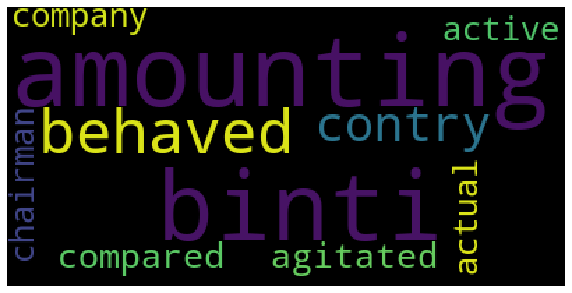

In [95]:
generateWConly(TfIdf_confirmed)

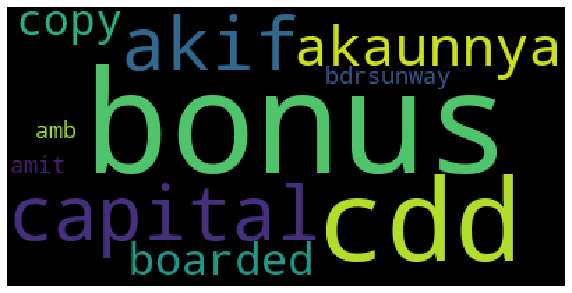

In [96]:
generateWConly(TfIdf_neutral)

In [97]:
#confirmedTextBigram = generateNGram(confirmedTextProcessed, 2)
df_IDFconfirmedBigram = generateTFIDF_df(confirmedTextBigram)
df_IDFneutralBigram = generateTFIDF_df(neutralTextBigram)

In [98]:
n = 100
TfIdf_confirmed = dict(sorted(list(zip(df_IDFconfirmedBigram.columns, df_IDFconfirmedBigram.max(axis = 1))),
                       key = lambda x:x[1], reverse = True)[:n])
TfIdf_neutral = dict(sorted(list(zip(df_IDFneutralBigram.columns, df_IDFneutralBigram.max(axis = 1))),
                       key = lambda x:x[1], reverse = True)[:n])

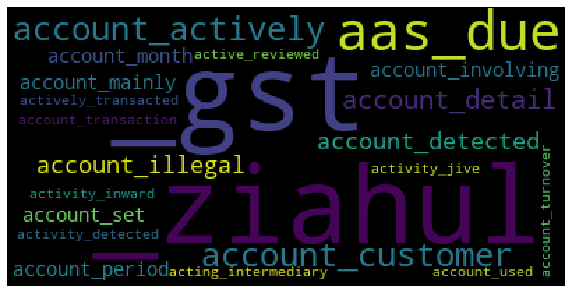

In [99]:
generateWConly(TfIdf_confirmed)

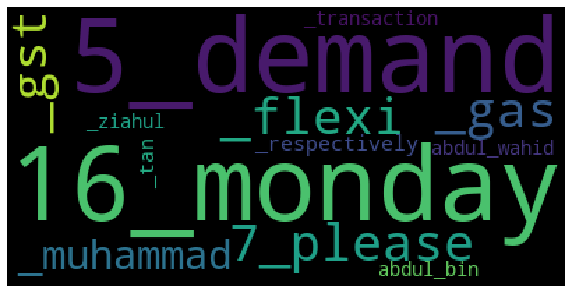

In [100]:
generateWConly(TfIdf_neutral)

TD-IDF for bigrams shows some useful unique bigrams for confirmed, noisy bigrams however for neutral tedt

# Word Embeddings

In [ ]:
#provide word representation in a dense vector space
#two different ways from what i found so far
#(a) gensim library
#(b) word2vec - CBOW (continuous bag of words) and skip grams 
#    CBOW - predict words given context
#    skip-grams - predict context given word